# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.5.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CuArrays"
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 2


# Adding packages utilised



In [ ]:
import Pkg

In [ ]:
Pkg.add("Word2Vec")
Pkg.add("Gadfly")
Pkg.add("TextAnalysis")
Pkg.add("Distances")
Pkg.add("Statistics")
Pkg.add("MultivariateStats")
Pkg.add("PyPlot")
Pkg.add("WordTokenizers")
Pkg.add("DelimitedFiles")
Pkg.add("Plots")

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/

In [ ]:
using Word2Vec
using Distances, Statistics
using MultivariateStats
using PyPlot
using Gadfly
using WordTokenizers
using TextAnalysis
using DelimitedFiles

┌ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1278
┌ Info: Precompiling WordTokenizers [796a5d58-b03d-544a-977e-18100b691f6e]
└ @ Base loading.jl:1278
┌ Info: Precompiling TextAnalysis [a2db99b7-8b79-58f8-94bf-bbc811eef33d]
└ @ Base loading.jl:1278


**Function used to load the data from 'glove.6B.50d.txt'**

In [ ]:
function load_embeddings(embedding_file)
    local LL, indexed_words, index
    indexed_words = Vector{String}()
    LL = Vector{Vector{Float32}}()
    open(embedding_file) do f
        index = 1
        for line in eachline(f)
            xs = split(line)
            word = xs[1]
            push!(indexed_words, word)
            push!(LL, parse.(Float32, xs[2:end]))
            index += 1
        end
    end
    return reduce(hcat, LL), indexed_words
end

load_embeddings (generic function with 1 method)

**Function used to quantify the vector value of a given word**

In [ ]:
function vec(s) 
    if glove_vec_idx(s) != nothing
        embeddings[:, glove_vec_idx(s)]
    end    
end

vec (generic function with 1 method)

**Function used to check the closest n number of words in contrast to a given word**

In [ ]:
function closest(v, n=11)
    list=[(x,cosine(embeddings'[x,:], v)) for x in 1:size(embeddings)[2]]
    topn_idx = sort(list, by = x -> x[2], rev = true)[1:n]
    return [vocab[a] for (a,_) in topn_idx]
end

closest (generic function with 2 methods)

**Function used to find the mean vector of each sentence by taking the vectors of each word**

In [ ]:
function sentvec(s) 
    local arr=[]
    for w in split(sentences[s])
        if vec(w)!=nothing
            push!(arr, vec(w))
        end
    end
    if length(arr)==0
        ones(Float32, (50,1))*999
    else
        mean(arr)
    end
end

sentvec (generic function with 1 method)

**Function used return nearest n neightbours with respect to sentence string given as input**

In [ ]:
function closest_sent(input_str, n=20)
    mean_vec_input=mean([vec(w) for w in split(input_str)])
    list=[(x,cosine(mean_vec_input, sentvec(x))) for x in 1:length(sentences)]
    topn_idx=sort(list, by = x -> x[2], rev=true)[1:n]
    return [sentences[a] for (a,_) in topn_idx]
end

closest_sent (generic function with 2 methods)

**Same function as above except this one uses pretrained data as input for a faster ouput for a given sentence**

In [ ]:
function closest_sent_pretrained(pretrained_arr, input_str, n=20)
    mean_vec_input=mean([vec(w) for w in split(input_str)])
    list=[(x,cosine(mean_vec_input, pretrained_arr[x,:])) for x in 1:length(sentences)]
    topn_idx=sort(list, by = x -> x[2], rev=true)[1:n]
    return [sentences[a] for (a,_) in topn_idx]
end

closest_sent_pretrained (generic function with 2 methods)

## Using Word2Vec to quantify data



**Create files and models for text8 data**

**Text8 vector**

In [ ]:
# create a vectorized txt file
word2vec("text8", "text8-vector.txt", verbose=true)

Starting training using file text8
Vocab size: 71291
Words in train file: 16718843
Alpha: 0.000002  Progress: 100.03%  Words/thread/sec: 385.84k  

Process(`/root/.julia/artifacts/0c86f7feb8f6b4ab5f9fb793f1fde1278e3a6021/bin/word2vec -train text8 -output text8-vector.txt -size 100 -window 5 -sample 0.001 -hs 0 -negative 5 -threads 12 -iter 5 -min-count 5 -alpha 0.025 -debug 2 -binary 0 -cbow 1`, ProcessExited(0))

In [ ]:
# create a model for text8
text8_model = wordvectors("text8-vector.txt")

WordVectors 71291 words, 100-element Float64 vectors

In [ ]:
# describe the model
text8_vec_size, text8_vocab_size = size(text8_model)
println("Loaded embeddings for text8-vector file, each word is represented by a vector with $text8_vec_size features. The vocab size is $text8_vocab_size")

Loaded embeddings for text8-vector file, each word is represented by a vector with 100 features. The vocab size is 71291


**Text8-phrases vector**

In [ ]:
# create a vectorized txt file that houses the phrases
word2phrase("text8", "text8phrase")
word2vec("text8phrase", "text8phrase-vector.txt", verbose=true)

tcmalloc: large alloc 2000003072 bytes == 0x26e2000 @  0x7f6dd020a001 0x400b68 0x7f6dcf848bf7 0x400c43


Starting training using file text8

Vocab size (unigrams + bigrams): 2419827
Words in train file: 17005206
Starting training using file text8phrase
Vocab size: 98331
Words in train file: 15857306
Alpha: 0.000002  Progress: 100.03%  Words/thread/sec: 379.39k  

Process(`/root/.julia/artifacts/0c86f7feb8f6b4ab5f9fb793f1fde1278e3a6021/bin/word2vec -train text8phrase -output text8phrase-vector.txt -size 100 -window 5 -sample 0.001 -hs 0 -negative 5 -threads 12 -iter 5 -min-count 5 -alpha 0.025 -debug 2 -binary 0 -cbow 1`, ProcessExited(0))

In [ ]:
# create a model based on text8phrase data
text8_model_phrases = wordvectors("text8phrase-vector.txt")

WordVectors 98331 words, 100-element Float64 vectors

In [ ]:
# describe the model based on text8phrase data
text8_phrases_vec_size, text8_phrases_vocab_size = size(text8_model_phrases)
println("Loaded embeddings for text8 phrase-vector file, each word is represented by a vector with $text8_phrases_vec_size features. The vocab size is $text8_phrases_vocab_size")

Loaded embeddings for text8 phrase-vector file, each word is represented by a vector with 100 features. The vocab size is 98331


**Text8-cluster**

In [ ]:
# create an indexed cluster file using the text8 data
word2clusters("text8", "text8-cluster.txt", 100)

Starting training using file text8
Vocab size: 71291
Words in train file: 16718843
Alpha: 0.020006  Progress: 19.99%  Words/thread/sec: 377.40k  

Process(`/root/.julia/artifacts/0c86f7feb8f6b4ab5f9fb793f1fde1278e3a6021/bin/word2vec -train text8 -output text8-cluster.txt -size 100 -window 5 -sample 0.0 -hs 0 -negative 5 -threads 1 -iter 5 -min-count 5 -alpha 0.025 -debug 2 -binary 0 -cbow 1 -classes 100`, ProcessExited(0))

In [ ]:
text8_model_cluster = wordclusters("text8-cluster.txt")

WordClusters 71291 words, 100 clusters

In [ ]:
# describe the model
text8_clusters_vec_size, text8_clusters_vocab_size = clusters(text8_model_cluster)
println("Loaded embeddings for text8 clusters file, each word is represented by a vector with $text8_clusters_vec_size features. The vocab size is $text8_clusters_vocab_size")

Loaded embeddings for text8 clusters file, each word is represented by a vector with 0 features. The vocab size is 1


**For data in glove.6B.50d.txt**

In [ ]:
embeddings, vocab = load_embeddings("glove.6B.50d.txt")
glove_vec_size, glove_vocab_size = size(embeddings)
println("Loaded embeddings for Glove.6B.50d file, each word is represented by a vector with $glove_vec_size features. The vocab size is $glove_vocab_size")

Loaded embeddings for Glove.6B.50d file, each word is represented by a vector with 50 features. The vocab size is 400001


**Look for index of word "X" in glove data**

In [ ]:
# check index number of given word, in this case "cheese"
glove_vec_idx(s) = findfirst(x -> x==s, vocab)
println("The index number for 'cheese' is: ", glove_vec_idx("cheese"))

The index number for 'cheese' is: 5796


In [ ]:
text8_words = vocabulary(text8_model)

71291-element Array{String,1}:
 "</s>"
 "the"
 "of"
 "and"
 "one"
 "in"
 "a"
 "to"
 "zero"
 "nine"
 "two"
 "is"
 "as"
 ⋮
 "raam"
 "barad"
 "baume"
 "mothmen"
 "gallopin"
 "horsecollar"
 "mojitos"
 "snaggletooth"
 "introvigne"
 "denishawn"
 "tamiris"
 "dolophine"

In [ ]:
# check index number of given word, in this case "hungary"
test8_vec_idx(s) = findfirst(x -> x==s, text8_words)
println("The index number for 'hungary' is: ", test8_vec_idx("hungary"))

The index number for 'hungary' is: 1711


**Check the vector value for a few words as tests**

In [ ]:
vec("cheese")

50-element Array{Float32,1}:
 -0.053903
 -0.30871
 -1.3285
 -0.43342
  0.31779
  1.5224
 -0.6965
 -0.037086
 -0.83784
  0.074107
 -0.30532
 -0.1783
  1.2337
  ⋮
  1.9502
 -0.53274
  1.1359
  0.20027
  0.02245
 -0.39379
  1.0609
  1.585
  0.17889
  0.43556
  0.68161
  0.066202

In [ ]:
vec("queen")

50-element Array{Float32,1}:
  0.37854
  1.8233
 -1.2648
 -0.1043
  0.35829
  0.60029
 -0.17538
  0.83767
 -0.056798
 -0.75795
  0.22681
  0.98587
  0.60587
  ⋮
 -0.83744
 -1.0326
  0.45946
  0.25302
 -0.17837
 -0.73398
 -0.20025
  0.2347
 -0.56095
 -2.2839
  0.0092753
 -0.60284

**Testing similarity scores**


In [ ]:
similarity(text8_model, "jupiter", "neptune")

0.8612812966302152

In [ ]:
similarity(text8_model, "santa", "snow")


0.3004533050683777

In [ ]:
similarity(text8_model, "hungary", "neptune")


0.0508136713940071

In [ ]:
similarity(text8_model, "milk", "cheese")

0.8521430589591775

**Testing dissimilarity scores**

In [ ]:
similarity(text8_model, "nutmeg", "football")

-0.1207981274737589

In [ ]:
similarity(text8_model, "book", "sugar")

-0.11597841830958602

In [ ]:
similarity(text8_model, "maroon", "messages")

-0.13767248709709898

In [ ]:
Word2Vec.cosine(x,y)=1-cosine_dist(x, y)

In [ ]:
println("is the similarity between 'dog' and 'cat' greater than the similarity between 'moon' and 'man'?\n", 
"----> ", cosine(vec("dog"), vec("cat")) > cosine(vec("moon"), vec("man")))

is the similarity between 'dog' and 'cat' greater than the similarity between 'moon' and 'man'?
----> true


**Similar word check in relation to 'hungary' & graph to show data visually**

In [ ]:
# find similar words to 'hungary', limit to 22 words
text8_vec_idx_1, text8_dists = cosine(text8_model, "hungary", 22)

([1711, 1465, 1294, 3006, 3680, 2067, 6255, 4023, 3174, 3967  …  750, 4138, 7553, 2559, 4383, 3742, 4344, 6258, 4435, 6687], [1.0, 0.8944348552305843, 0.8588689077477858, 0.8418338263993157, 0.8243089722879713, 0.8223834757420273, 0.8217938427905108, 0.8191628615267543, 0.8176203548781392, 0.806641833025856  …  0.7901767437045633, 0.7828015510157531, 0.7736189560677966, 0.7675659110430186, 0.766358410502749, 0.7624761213862503, 0.7606688210894433, 0.7562732055051318, 0.7495012902742589, 0.7441245596505028])

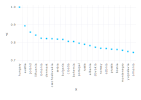

In [ ]:
Gadfly.plot(x = text8_words[text8_vec_idx_1], y = text8_dists)

**Tests for closest words to a given word**

In [ ]:
closest(vec("wine"))

11-element Array{String,1}:
 "wine"
 "wines"
 "tasting"
 "coffee"
 "beer"
 "champagne"
 "drink"
 "taste"
 "grape"
 "drinks"
 "beers"

In [ ]:
closest(vec("water") + vec("frozen"))

11-element Array{String,1}:
 "water"
 "frozen"
 "dry"
 "dried"
 "salt"
 "milk"
 "oil"
 "waste"
 "liquid"
 "ice"
 "freezing"

In [ ]:
closest(mean([vec("day"), vec("night")]))

11-element Array{String,1}:
 "night"
 "day"
 "days"
 "weekend"
 "morning"
 "sunday"
 "afternoon"
 "saturday"
 "came"
 "week"
 "evening"

In [ ]:
blue_to_sky = vec("blue") - vec("sky")
closest(blue_to_sky + vec("grass"))

11-element Array{String,1}:
 "grass"
 "green"
 "leaf"
 "cane"
 "bamboo"
 "trees"
 "grasses"
 "tree"
 "yellow"
 "lawn"
 "cotton"

In [ ]:
closest(vec("man") - vec("woman") + vec("queen"))


11-element Array{String,1}:
 "queen"
 "king"
 "prince"
 "crown"
 "coronation"
 "royal"
 "knight"
 "lord"
 "lady"
 "ii"
 "great"

In [ ]:
closest(vec("king") - vec("queen") + vec("woman"))


11-element Array{String,1}:
 "man"
 "father"
 "who"
 "woman"
 "death"
 "another"
 "whose"
 "old"
 "victim"
 "him"
 "boy"

**Check to show similar words between given words**

In [ ]:
analogy_words(text8_model, ["hungary", "estonia"], ["belarus"], 10)

10-element Array{String,1}:
 "denmark"
 "norway"
 "portugal"
 "austria"
 "sweden"
 "romania"
 "poland"
 "belgium"
 "luxembourg"
 "bohemia"

In [ ]:
analogy_words(text8_model, ["tree", "leaf"], ["bark"], 10)

10-element Array{String,1}:
 "cluster"
 "chromosome"
 "trees"
 "avl"
 "flower"
 "node"
 "bird"
 "heap"
 "triangle"
 "vertex"

In [ ]:
cosine_similar_words(text8_model_phrases, "new_jersey", 5)

5-element Array{String,1}:
 "new_jersey"
 "pennsylvania"
 "north_carolina"
 "oklahoma"
 "massachusetts"

**Scaling up to full sentences in the book macbeth**

In [ ]:
txt = open("macbeth.txt") do file
    read(file, String)
end
println("Loaded Macbeth, length = $(length(txt)) characters")

Loaded Macbeth, length = 119886 characters


In [ ]:
txt = replace(txt, r"\n|\r|_|," => " ")
txt = replace(txt, r"[\"*();!]" => "")
sd=StringDocument(txt)
prepare!(sd, strip_whitespace)
sentences = split_sentences(sd.text)
i=1
for s in 1:length(sentences)
    if length(split(sentences[s]))>3
        sentences[i]=lowercase(replace(sentences[s], "."=>""))
        i+=1
    end
end
sentences[1000:1010]

11-element Array{SubString{String},1}:
 "Some holy angel Fly to the court of England and unfold His message ere he come that a swift blessing May soon return to this our suffering country Under a hand accurs'd LORD."
 "I'll send my prayers with him."
 "[Exeunt.] ACT IV."
 "SCENE I."
 "A dark Cave."
 "In the middle a Caldron Boiling."
 "[Thunder. Enter the three Witches.] FIRST WITCH."
 "Thrice the brinded cat hath mew'd."
 "SECOND WITCH."
 "Thrice and once the hedge-pig whin'd."
 "THIRD WITCH."

In [ ]:
sentences[22]

"we need your donations more than ever all donations should be made to project gutenberg/cmu: and are tax deductible to the extent allowable by law"

In [ ]:
sentvec(22)

50-element Array{Float32,1}:
  0.37784204
  0.114053465
  0.18923575
 -0.3815774
  0.26328376
  0.28519785
 -0.25182453
 -0.2837967
  0.10584256
  0.05207872
 -0.09566488
  0.23670004
  0.014222746
  ⋮
  0.01329596
 -0.20304763
 -0.259647
  0.011060621
  0.21583354
  0.47177097
 -0.2735853
 -0.18427198
 -0.38094747
  0.2206186
 -0.1340036
  0.070441045

In [ ]:
closest_sent("my favorite food is strawberry ice cream")

20-element Array{SubString{String},1}:
 "Dispute it like a man."
 "cool it with a baboon's blood then the charm is firm and good"
 "fillet of a fenny snake in the caldron boil and bake eye of newt and toe of frog wool of bat and tongue of dog adder's fork and blind-worm's sting lizard's leg and howlet's wing -- for a charm of powerful trouble like a hell-broth boil and bubble"
 "How now you secret black and midnight hags What is't you do?"
 "what three things does drink especially provoke?"
 "where is your husband?"
 "my hands are of your color but i shame to wear a heart so white"
 "there if i grow the harvest is your own"
 "Thou are too like the spirit of Banquo down Thy crown does sear mine eyeballs:--and thy hair Thou other gold-bound brow is like the first-- A third is like the former.--Filthy hags Why do you show me this?--A fourth--Start eyes What will the line stretch out to the crack of doom?"
 "sweet remembrancer-- now good digestion wait on appetite and health on both lennox

In [ ]:
macbeth_sent_vecs=[]
for s in 1:length(sentences)
    i==1 ? macbeth_sent_vecs=sentvec(s) : push!(macbeth_sent_vecs,sentvec(s))
end

In [ ]:
writedlm( "macbeth_sent_vec.csv",  macbeth_sent_vecs, ',')


In [ ]:
writedlm( "macbeth_sentences.csv",  sentences, ',')


In [ ]:
sentences=readdlm("macbeth_sentences.csv", '!', String, header=false)
macbeth_sent_vecs=readdlm("macbeth_sent_vec.csv", ',', Float32, header=false)

1649×50 Array{Float32,2}:
   0.218204    0.15257     -0.0881015   …   -0.00134969    -0.125002
   0.217248    0.170891     0.277308        -0.00419656     0.0283584
   0.418575   -0.0769       0.0130888        0.0883818      0.224493
   0.350422    0.0837956    0.117248        -0.128123      -0.34731
   0.460269    0.2135       0.3541          -0.106532       0.398037
   0.37649     0.117803    -0.197311    …   -0.0742857     -0.0264935
   0.329592    0.214679    -0.113543        -0.126887      -0.251263
   0.209353    0.0975065   -0.115255        -0.0484852      0.041582
   0.302883    0.127629     0.0802725       -0.15581       -0.108064
   0.375961    0.25363     -0.122392        -0.0311806     -0.174761
   0.358873    0.311653    -0.108573    …   -0.0476981     -0.282434
   0.329278   -0.0517918   -0.00524605      -0.000999476    0.154879
   0.267911    0.210859     0.144728        -0.0236636     -0.0472872
   ⋮                                    ⋱                 
   0.40329    -0

In [ ]:
closest_sent_pretrained(macbeth_sent_vecs, "i stabbed him in the back")

20-element Array{String,1}:
 "your son my lord has paid a soldier's debt: he only liv'd but till he was a man the which no sooner had his prowess confirm'd in the unshrinking station where he fought but like a man he died"
 "Your son my lord has paid a soldier's debt: He only liv'd but till he was a man The which no sooner had his prowess confirm'd In the unshrinking station where he fought But like a man he died."
 "he's here in double trust: first as i am his kinsman and his subject strong both against the deed: then as his host who should against his murderer shut the door not bear the knife myself"
 "out damned spot out i say-- one two why then 'tis time to do't --hell is murky--fie my lord fie a soldier and afeard?"
 "he has kill'd me mother: run away i pray you [dies exit lady macduff crying murder and pursued by the murderers] scene iii"
 "but i have spoke with one that saw him die: who did report that very frankly he confess'd his treasons implor'd your highness' pardon and set